In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# import pynninterp
import numpy as np
from resonance import plotting
from metpy.interpolate import interpolate_to_points

from resonance.neuralnodes import func, kernel, utils

from resonance.mother.params import Params
from resonance.mother.model import run_model


plt.style.use('ncb.mplstyle')

p = Params.from_yaml('params/mother_anu-refit_params.yaml')
p

Params(an1_filter_inh_dur=293.04787364263365, an1_filter_inh_sigma=3.813854587313954, an1_filter_inh_gain=0.8774626787707686, an1_filter_delay=2.265900245685722, an1_filter_exc_dur=7.595353003606418, an1_filter_exc_sigma=3.88133594573093, an1_ada_filter_tau=9999.937896100262, an1_ada_strength=85.7524637276691, an1_nonlinearity_slope=10.339203679576736, an1_nonlinearity_shift=0.6271689149854863, an1_nonlinearity_gain=1.1986301801194412, an1_nonlinearity_baseline=-0.29039727235773805, an1_ln2_delay=7.594355080977287, an1_ln2_gain=1.9385802639842316, ln2_filter_inh_tau=15.87651494956352, ln2_filter_exc_dur=11.876728540999014, ln2_filter_exc_sigma=9.766257228790783, ln2_filter_exc_gain=0.5937909616247742, ln2_nonlinearity_gain=4.224823085932915, ln2_ln5_gain=0.4343449500755029, ln2_ln5_delay=13.131162447090048, ln5_ada_filter_dur=8.940772033373342, ln5_ada_filter_exc_gain=0.41860267512442684, ln5_filter_exc_tau=0.025568053678884418, ln5_filter_exc_dur=5.187367599423327, ln5_filter_exc_gain

In [3]:

def interp_ppf(pdur, ppau, ppf, pduri, ppaui):
    pdur_grid, ppau_grid = np.meshgrid(pdur,ppau)
    points = np.array([pdur_grid + np.random.randn(*pdur_grid.shape)/1_000, ppau_grid+ np.random.randn(*ppau_grid.shape)/1_000]).T.reshape((-1, 2))

    pduri_grid, ppaui_grid = np.meshgrid(pduri, ppaui)
    new_points = np.array([pduri_grid, ppaui_grid]).T.reshape((-1, 2))

    ppf = interpolate_to_points(points, ppf, new_points, interp_type='natural_neighbor', minimum_neighbors=3)
    ppf = np.maximum(ppf, 0)
    ppf = ppf.reshape((len(pduri_grid), len(ppaui_grid)))
    return ppf


In [4]:
input_stim, s, ppau, pdur = utils.makePPFstim(ppauMax=20, pdurMax=20, cdur=200, cpau=0, Fs=1000,  step=1)
# ppau1d=np.repeat(ppau,np.size(pdur)).astype(float)
# pdur1d=np.tile(pdur,np.size(ppau)).astype(float)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


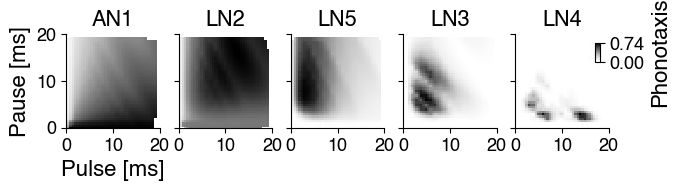

In [6]:
pdur = ppau = np.arange(0, 20, 1)

out = np.load('dat/MdlOut.npy')
# pdur = ppau = np.arange(0, 20, 1)
ppaui = pduri = np.arange(0, 20, .5)

plt.figure(figsize=(7, 3))
for cel, name in enumerate(['AN1', 'LN2', 'LN5', 'LN3' ,'LN4']):
    ppf = np.nanmean(np.clip(out[cel], 0, np.inf), axis=0)
    plt.subplot(1, len(out), cel+1)
    ppfi = interp_ppf( pdur, ppau, ppf, pduri, ppaui)
    plotting.ppf(pduri, ppaui, ppfi, colorbar=cel>3)

    ax = plt.gca()
    ax.set_xticks([0, 10, 20])
    ax.set_yticks([0, 10, 20])
    ax.set_title(name)
    if cel>0:
        ax.set_yticks([0, 10, 20], labels=[])
        ax.set_ylabel('')
        ax.set_xlabel('')
plt.savefig("fig/Fig_mother_E.pdf")
plt.show()

In [7]:
ppaui = pduri = np.arange(0, 20, .5)
new_points = np.array(np.meshgrid(pduri,ppaui)).reshape((2, -1)).T
new_points = new_points[:, ::-1]
ppfi = interp_ppf(pdur, ppau, ppf, pduri, ppaui)

ppfi.flatten().shape, pduri.shape, new_points.shape

((1600,), (40,), (1600, 2))

<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:50: SyntaxWarning: invalid escape sequence '\D'
/var/folders/lz/h0pd23610q36ss5zm1x9kfn0gy02sm/T/ipykernel_7253/1777973979.py:50: SyntaxWarning: invalid escape sequence '\D'
  for per, frq, col in zip(pers, ['$\Delta/4$', '$\Delta/2=T_{s}$', '$\Delta$'], col_per):
/var/folders/lz/h0pd23610q36ss5zm1x9kfn0gy02sm/T/ipykernel_7253/1777973979.py:50: SyntaxWarning: invalid escape sequence '\D'
  for per, frq, col in zip(pers, ['$\Delta/4$', '$\Delta/2=T_{s}$', '$\Delta$'], col_per):
/var/folders/lz/h0pd23610q36ss5zm1x9kfn0gy02sm/T/ipykernel_7253/1777973979.py:50: SyntaxWarning: invalid escape sequence '\D'
  for per, frq, col in zip(pers, ['$\Delta/4$', '$\Delta/2=T_{s}$', '$\Delta$'], col_per):
/var/folders/lz/h0pd23610q36ss5zm1x9kfn0gy0

<Figure size 1000x250 with 0 Axes>

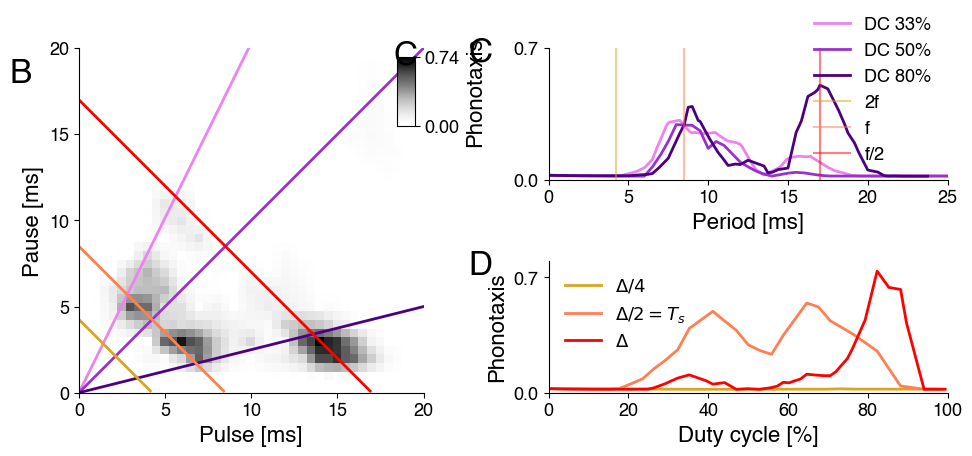

In [8]:
out = np.load('../mothernetwork/res/MdlOut.npy')

fs = 10_000.0
stim_step = 0.1
max_len = 20

plt.figure(figsize=(10, 2.5))
# for cel in range(len(out)):
cel = 4
ppf = np.nanmean(np.clip(out[cel], 0, np.inf), axis=0)
# plt.subplot(1, len(out), cel+1)

axs = [None, None, None]

plt.figure(figsize=(15, 4.5))

axs[0] = plt.subplot(131)
plotting.ppf(pduri, ppaui, ppfi, ax=axs[0])

axs[1] = plt.subplot(232)
axs[2] = plt.subplot(235)


col_dc = ['violet', 'darkorchid', 'indigo']
col_per = ['goldenrod', 'coral', 'red']

dcs = [0.33, 0.5, 0.8]
T = 17.0
pers = [T/4, T/2, T]

# period transects
plt.sca(axs[1])
for dc, col in zip(dcs, col_dc):
    dur = np.arange(0, max_len+0.1, 0.01)
    pau = dur / dc - dur
    dur = dur[pau <= max_len]
    pau = pau[pau <= max_len]
    axs[0].plot(dur, pau, c=col, linewidth=2)
    plt.plot(pau+dur, plotting.transect(new_points, ppfi, dur, pau, grid=False), c=col, label=f'DC {dc * 100:1.0f}%', linewidth=2.0)
plt.xlabel('Period [ms]')
for f, c, l in zip(pers, col_per, ['2f', 'f', 'f/2']):
    plt.axvline(f, c=c, alpha=0.5, label=l)
plt.xlim(0, 25)
plt.yticks([0, 0.7])
plt.legend(frameon=False)

# DC transects
plt.sca(axs[2])
per = 10
for per, frq, col in zip(pers, ['$\Delta/4$', '$\Delta/2=T_{s}$', '$\Delta$'], col_per):
    pau = np.arange(0.1, per, 0.01)
    dur = per - pau
    dc = dur / per
    dur = dur[pau <= max_len]
    pau = pau[pau <= max_len]
    axs[0].plot(dur, pau, c=col, linewidth=2)
    plt.plot(dc * 100, plotting.transect(new_points, ppfi, dur, pau, grid=False), c=col, label=f'{frq}', linewidth=2.0)
plt.xlabel('Duty cycle [%]')
plt.ylabel('Phonotaxis')
# for d, c, l in zip(dcs, col_dc, dcs):
#     plt.axvline(d * 100, c=c, alpha=0.5, label=l)
plt.xlim(0, 100)
plt.yticks([0, 0.7])
plt.legend(frameon=False)

plotting.label_axes(labels='BCCD')
plt.tight_layout()

plt.savefig(f'fig/Fig_mother-B-D.pdf')

In [13]:
def nm(x):
    return x / np.nanmax(x)

yppau=np.repeat(ppau,np.size(pdur)).astype(float)
xpdur=np.tile(pdur,np.size(ppau)).astype(float)
ppers = np.zeros(np.size(xpdur))
pdcs = np.zeros(np.size(xpdur))
for i in range(np.size(xpdur)):
    ppers[i]=((yppau[i]+xpdur[i]))
    pdcs[i] = xpdur[i]*10 / (ppers[i])
xi0 = np.arange(0, 25.0, .1)
yi0 = np.arange(0, 10.0, .05)
xi,yi = np.meshgrid(xi0,yi0)

nn = pynninterp.NaturalNeighbour


fig = plt.figure(figsize=(9, 2))

xnums = np.linspace(0,25,250)
# out = run_model(input_stim, p,verbose_output=True)
out = np.load('dat/MdlOuts-anu-verbose-noparam.npy')
plt.subplot(131)
output_trans = np.nan_to_num(nn(ppers, np.nan_to_num(pdcs), np.nanmean(out[4], axis=0).astype(float), xi, yi))

plt.plot(xnums,nm(np.mean(output_trans[100:,:],axis=0)),label='LN3',color='purple')
output_trans = np.nan_to_num(nn(ppers, np.nan_to_num(pdcs), np.nanmean(out[7], axis=0).astype(float), xi, yi))
plt.plot(xnums, nm(np.mean(output_trans[100:,:],axis=0)),label='LN4',color='grey')
plt.ylabel('Norm. resp.')
plt.xlabel('Period [ms]')
plt.xlim(0,25)
plt.ylim(0, 1)
plt.yticks([0, 1])

plt.subplot(132)
xnums = np.linspace(0,100,200)
# output_trans = np.nan_to_num(nn(ppers, np.nan_to_num(pdcs), np.nanmean(out[1], axis=0).astype(float), xi, yi))
# plt.plot(xnums, nm(np.mean(output_trans[:,170:180],axis=1)),label='LN2',color='blue')
output_trans = np.nan_to_num(nn(ppers, np.nan_to_num(pdcs), np.nanmean(out[4], axis=0).astype(float), xi, yi))
plt.plot(xnums, nm(np.mean(output_trans[:,170:180],axis=1)),label='LN3',color='purple')
output_trans = np.nan_to_num(nn(ppers, np.nan_to_num(pdcs), np.nanmean(out[7], axis=0).astype(float), xi, yi))
plt.plot(xnums, nm(np.mean(output_trans[:,170:180], axis=1)), label='LN4',color='grey')
plt.ylim(0)
# plt.ylabel('Norm. resp.')
plt.xlabel('Duty cycle [%]')
plt.yticks([0, 1])
plt.legend()

plt.tight_layout()
plt.savefig("fig/Fig_mother-FG.pdf")
plt.show()

/var/folders/lz/h0pd23610q36ss5zm1x9kfn0gy02sm/T/ipykernel_7253/2529426886.py:10: RuntimeWarning: invalid value encountered in scalar divide
  pdcs[i] = xpdur[i]*10 / (ppers[i])


NameError: name 'pynninterp' is not defined

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


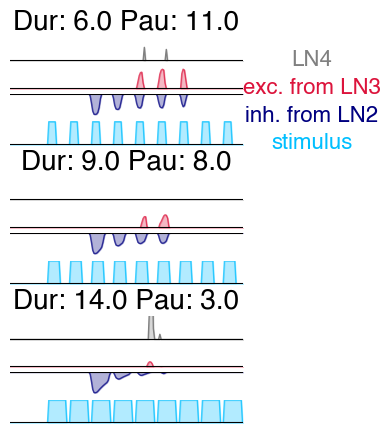

In [12]:
def get_trace_full(neuron, song):
    return out[neuron][:, song]

def make_axs_plt_simple(idx, num, out, off=0):
    ln3_ln4_output = func.synapse(np.expand_dims(out[5][:, idx], axis=1), p.ln3_ln4_delay, p.ln3_ln4_gain)

    x = np.arange(len(input_stim[:, idx].flatten()))
    axs[off + 3].plot(input_stim[:, idx], linewidth=1, color="deepskyblue", alpha=0.7)
    axs[off + 3].fill_between(x, 0, input_stim[:, idx].flatten(), interpolate=True, color="deepskyblue", alpha=0.3)
    axs[off + 3].axhline(0, c='k')
    axs[off + 3].set_ylim(0, 1.01)

    axs[off + 2].plot(get_trace_full(6, idx), linewidth=1, color="navy", alpha=0.7)
    axs[off + 2].fill_between(x, 0, get_trace_full(6, idx), interpolate=True, color="navy", alpha=0.3)
    axs[off + 2].axhline(0, c='k')
    axs[off + 2].set_ylim(-400, 0)

    axs[off + 1].plot(ln3_ln4_output, linewidth=1, color="crimson", alpha=0.7)
    axs[off + 1].fill_between(x, 0, ln3_ln4_output.flatten(), interpolate=True, color="crimson", alpha=0.3)
    axs[off + 1].axhline(0, c='k')
    axs[off + 1].set_ylim(0, 60)

    axs[off + 0].plot(get_trace_full(7, idx), linewidth=1, label="out", color="grey")
    axs[off + 0].fill_between(x, 0, get_trace_full(7, idx).flatten(), interpolate=True, color="grey", alpha=0.3)
    axs[off + 0].set(ylim=(0, 15))
    axs[off + 0].set_title(f"Dur: {new_points[idx][1]} Pau: {new_points[idx][0]}", fontsize=20)
    axs[off + 0].axhline(0, c='k')
    axs[off + 0].set_ylim(0, 20)

    for ax in axs:
        ax.set(xlim=(150, 250))
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])


input_stim, s, ppau, pdur = utils.makePPFstim(ppauMax=20, pdurMax=20, cdur=200, cpau=0, Fs=1000, step=1)
new_points = np.array([s["ppau"], s["pdur"]]).T / 1000 * 1000

idxes = [226, 169, 74]
out = np.load("dat/MdlOuts-anu-verbose-noparam.npy")

fig, axs = plt.subplots(14, 1, sharex=True, sharey="none", figsize=(3, 5))

idx = idxes[0]
make_axs_plt_simple(idx, 1, out)

idx = idxes[1]
make_axs_plt_simple(idx, 2, out, off=5)

idx = idxes[2]
make_axs_plt_simple(idx, 3, out, off=10)

axs[3].set_ylabel("stimulus", rotation="horizontal", fontsize=16, labelpad=50, color="deepskyblue")
axs[2].set_ylabel("inh. from LN2", rotation="horizontal", fontsize=16, labelpad=50, color="navy")
axs[1].set_ylabel("exc. from LN3", rotation="horizontal", fontsize=16, labelpad=50, color="crimson")
axs[0].set_ylabel("LN4", rotation="horizontal", fontsize=16, labelpad=50, color="grey")

for ax in axs:
    ax.yaxis.set_label_position("right")
    ax.set(xlim=(20, 200))

plt.savefig("fig/Fig_mother-H.pdf")
plt.show()